In [ ]:
from importlib import reload
from recovar import EM_iteration as em
reload(em)
from recovar import mask
import numpy as np
import jax
from recovar.fourier_transform_utils import fourier_transform_utils
ftu = fourier_transform_utils(jax.numpy)

n = 16

translations = np.array([[0,0], [0,1]])#[0:1]
probabilities = np.array([0.3, 0.7])#[0:1]
translations = np.array([[0,0], [0,1]])#[1:2]
probabilities = np.array([0.3, 0.7])#[1:2]

image_shape = (n,n)
images_ift = mask.get_radial_mask(image_shape)
images = ftu.get_dft2(images_ift)
image_shape = images.shape

zz = em.sum_up_translate_one_image(images, probabilities, translations, image_shape, translation_fn= "nofft").reshape(image_shape)
zz_ift = ftu.get_idft2(zz)

zz2 = em.sum_up_translate_one_image(images, probabilities, translations, image_shape, translation_fn= "fft").reshape(image_shape)
zz2_ift = ftu.get_idft2(zz2)


/Users/marcaurele/research/recovar/recovar/EM_iteration.py:165: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  images_probs = jnp.zeros( image_size, dtype = probabilities.dtype)


In [38]:
import jax.numpy as jnp
grid_points = jnp.array( [[0.1, 0.2, 0.4]])

x_low = jnp.floor(grid_points).astype(int)
x_high = x_low + 1
weight_low = grid_points - x_low
weight_high = 1 - weight_low

xs = jnp.stack( [x_low, x_high], axis=-1)[0]

# def get_nearby_grid
def meshgrid_one(xs):
    # This is all to have to avoid writing 8 statements, which could be a poor decision?
    z = jnp.meshgrid(*xs, indexing="ij")
    return jnp.stack(z, axis=-1).reshape(-1, len(z)) #jnp.concatenate(z)

def get_stencil(dim):
    if dim==2:
        return jnp.array([[0, 0], [0,1], [1,0], [1,1]], dtype = int)
    if dim==3:
        return jnp.array([[0, 0, 0], [0, 0,1], [0, 1,0], [0, 1,1], \
                         [1, 0, 0], [1, 0,1], [1, 1,0], [1, 1,1]] , dtype = int)

from recovar.core import *

def get_trilinear_weights_and_vol_indices(grid_coords, volume_shape):

    # lower_grid_points = jnp.floor(grid_points).astype(int)
    lower_points_ndim = grid_coords.ndim-1
    all_grid_points = jnp.floor(grid_coords).astype(int)[...,None,:] + get_stencil(grid_coords.shape[-1]).reshape( [*(lower_points_ndim * [1]), 8,3])

    # This feels right, but is it?
    # all_weights = jnp.linalg.norm(all_grid_points - grid_coords[...,None,:], axis=-1)**2
    # all_weights /= jnp.linalg.norm(all_weights, axis=-1, keepdims=True)

    # This feels right, but is it?
    all_weights = jnp.prod(1 - jnp.abs(all_grid_points - grid_coords[...,None,:]), axis=-1)#**2
    # all_weights /= jnp.linalg.norm(all_weights, axis=-1, keepdims=True)

    # Zero-out out of bound for good measure.
    good_points = check_vol_indices_in_bound(all_grid_points, volume_shape[0])
    all_weights *= good_points

    return all_grid_points, all_weights


# @functools.partial(jax.jit, static_argnums = [2,3,4])    
def slice_volume_by_trilinear(volume, rotation_matrices, image_shape, volume_shape):    
    grid_coords, grid_coords_og_shape = rotations_to_grid_point_coords(rotation_matrices, image_shape, volume_shape)
    grid_points, weights = get_trilinear_weights_and_vol_indices(grid_coords.T, volume_shape)
    grid_vec_indices = vol_indices_to_vec_indices( grid_points, volume_shape)
    sliced_volume = jnp.sum(volume[grid_vec_indices.reshape(-1)].reshape(grid_vec_indices.shape) * weights, axis=-1)
    return sliced_volume.reshape(grid_coords_og_shape[:-1])


# @functools.partial(jax.jit, static_argnums = [2,3,4])    
## UNTESTED
def adjoint_slice_volume_by_trilinear(images, rotation_matrices, image_shape, volume_shape, volume = None):    
    grid_coords, _ = rotations_to_grid_point_coords(rotation_matrices, image_shape, volume_shape)
    grid_points, weights = get_trilinear_weights_and_vol_indices(grid_coords.T, volume_shape)
    grid_vec_indices = vol_indices_to_vec_indices( grid_points, volume_shape)
    if volume is None:
        volume = jnp.zeros(np.prod(volume_shape), dtype = images.dtype)
    weights *= images.reshape(-1,1)
    volume = volume.at[grid_vec_indices.reshape(-1)].set(weights.reshape(-1))
    return volume

# This is actually pretty stupid. Can just loop over labels...
## UNTESTED too. This is to speed up heterogeneity reconstruction
def adjoint_slice_multi_volume_by_trilinear(images, rotation_matrices, het, image_shape, volume_shape, het_shape, volume = None):    
    grid_coords, _ = rotations_to_grid_point_coords(rotation_matrices, image_shape, volume_shape)
    grid_points, weights = get_trilinear_weights_and_vol_indices(grid_coords.T, volume_shape)
    grid_vec_indices = multi_vol_indices_to_multi_vec_indices( grid_points, het, volume_shape, het_shape)

    if volume is None:
        volumes = jnp.zeros(np.prod(volume_shape) * het_shape, dtype = images.dtype)
    weights *= images.reshape(-1,1)
    volumes = volumes.at[grid_vec_indices.reshape(-1)].set(weights.reshape(-1))
    return volumes



grid_points = jnp.array([[ 2.1, 2.4, 3.7],[ 0.1, 0.2, 0.3]])


# lower_points = jnp.floor(grid_points).astype(int)
# lower_points_ndim = lower_points.ndim-1
# all_points = lower_points[...,None,:] + get_stencil(grid_points.shape[-1]).reshape( [*(lower_points_ndim * [1]), 8,3])
# # This feels right, but is it?
# all_weights = jnp.linalg.norm(all_points - grid_points[...,None,:], axis=-1)**2
# all_weights /= jnp.linalg.norm(all_weights, axis=-1, keepdims=True)
grid_size = 8
volume = np.random.randn(grid_size**3)
# from recovar.simulator import 
rot = np.array([[[ 1, 0, 0], [0,1,0], [0,0,1]]])
from recovar import simulator
rot = simulator.uniform_rotation_sampling(2, 0, seed = 0 )
all_points, all_weights =  get_trilinear_weights_and_vol_indices(grid_points, [10,10,10])
# meshgrid_indices = jax.vmap(meshgrid_one, in_axes=(-1))
vol_shape = tuple(3 * [grid_size])
image_shape = tuple(2 * [grid_size])
zz = slice_volume_by_trilinear(volume, rot, image_shape, vol_shape)
zz2 = slice_volume_by_map(volume, rot, image_shape, vol_shape, 'linear_interp')

zz3 = adjoint_slice_volume_by_trilinear(zz, rot, image_shape, vol_shape)
# zz2 = slice_volume_by_map(volume, rot, image_shape, vol_shape, 'linear_interp')

jnp.linalg.norm(zz-zz2) / jnp.linalg.norm(zz2)

Array(8.494914e-08, dtype=float32)

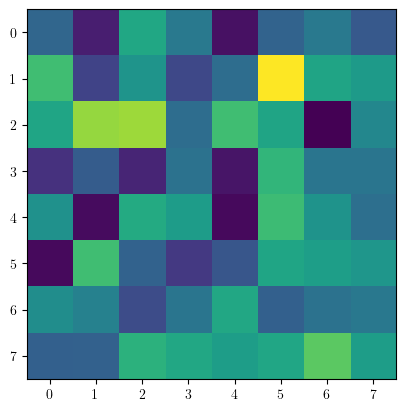

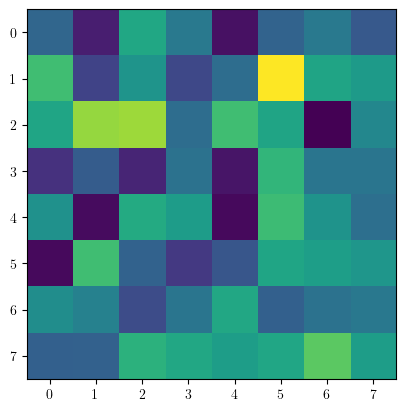

In [29]:
import matplotlib.pyplot as plt
plt.imshow(zz.reshape(image_shape))
plt.figure()
plt.imshow(zz2.reshape(image_shape))

In [23]:
zz

Array([[ 0.47549075,  0.20941675, -0.33769992,  0.29687437,  0.60114866,
        -0.81839645,  2.0158243 ,  0.        ,  0.5523861 ,  1.8434975 ,
        -0.5246171 , -0.98534125,  1.4132837 ,  0.4771548 ,  0.910032  ,
         0.        , -0.57368684,  1.2071528 , -0.24082638,  0.21318226,
         0.21612678,  1.1485624 ,  0.18560179,  0.        , -0.30011225,
        -0.02885382, -1.0509248 ,  0.8493402 , -0.5045329 ,  0.31250352,
        -0.16659853,  0.        ,  0.42467546, -2.0265615 , -0.5387535 ,
         1.5364498 ,  0.73498607, -0.87656766,  0.6049063 ,  0.        ,
        -1.2997651 ,  1.6696273 , -0.84541637, -0.16033544, -0.79165524,
         0.0560303 , -0.03373526,  0.        ,  1.0360807 , -2.1858633 ,
         0.3629446 ,  1.6357268 ,  0.9577152 , -0.47367424,  1.0868788 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

In [53]:
all_weights

Array([[0.21935752, 0.08641357, 0.28582942, 0.15288548, 0.48524544,
        0.35230142, 0.55171734, 0.41877335],
       [0.04226387, 0.1630178 , 0.2233948 , 0.34414864, 0.2837717 ,
        0.40452558, 0.46490264, 0.5856566 ]], dtype=float32)

In [51]:
all_weights

Array([[0.66000015, 0.26000005, 0.86      , 0.4599999 , 1.4600004 ,
        1.0600001 , 1.6600002 , 1.26      ],
       [0.14      , 0.53999996, 0.7400001 , 1.1399999 , 0.93999994,
        1.3399998 , 1.5400001 , 1.94      ]], dtype=float32)

In [45]:
all_points.shape

(2, 8, 3)

In [21]:
lower_points.shape
lower_points_ndim = lower_points.ndim-1

In [42]:
get_stencil(grid_points.shape[-1]).reshape( [*(lower_points_ndim * [1]), 8,3])

Array([[[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]], dtype=int32)

In [38]:
z = 3 *[1]

In [28]:
z

[1, 1, 1]

In [14]:
all_points = lower_points[...,None] + get_stencil(grid_points.shape[-1]).reshape(lower_points.shape)


TypeError: array() got an unexpected keyword argument 'type'

In [13]:
lower_points

Array([[2, 2, 3],
       [0, 0, 0]], dtype=int32)

In [11]:
meshgrid_one(jnp.zeros(0,0,0))

TypeError: zeros() takes from 1 to 2 positional arguments but 3 were given

In [10]:
z

Array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]], dtype=int32)

In [5]:
z = meshgrid_one(xs)

In [6]:
zz = jnp.meshgrid(*(xs.T), indexing="ij")


In [7]:
np.stack(zz, axis=-1).reshape(-1, len(zz))

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)

In [51]:
z = jnp.meshgrid(*xs.T)
z2 = np.concatenate(z)

In [52]:
z2.shape

(6, 2, 2)

In [39]:
xs.shape

(2, 3)

In [37]:
xs.shape

(2, 3)

In [36]:
jnp.concatenate(z)

Array([[[0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1]],

       [[0, 0],
        [0, 0]],

       [[1, 1],
        [1, 1]],

       [[0, 1],
        [0, 1]],

       [[0, 1],
        [0, 1]]], dtype=int32)

In [ ]:
# def get_nearby_grid
def mesh_grid_one(x_grid):
    z = jnp.meshgrid(low_high, low_high)
    return jnp.concatenate()
mesh_grid_coords = jax.vmap(mesh_grid_coords, in_axes=(-1))


x_low = jnp.floor(grid_points).astype(int)
x_high = x_low + 1
weight_low = grid_points - x_low
weight_high = 1 - weight_low

xs = jnp.concatenate( [x_low, x_high])



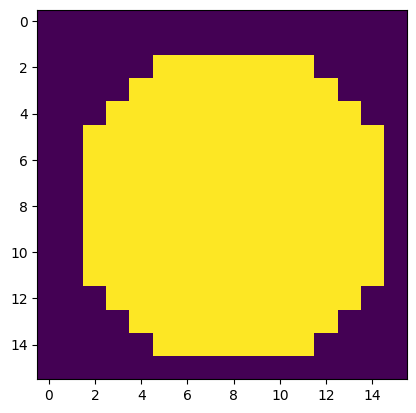

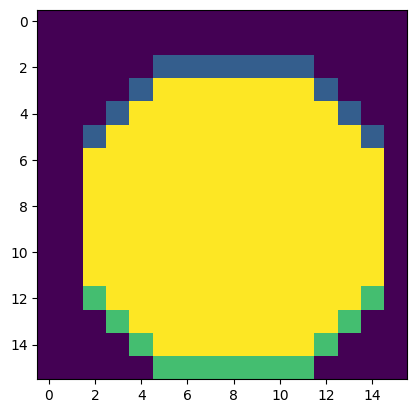

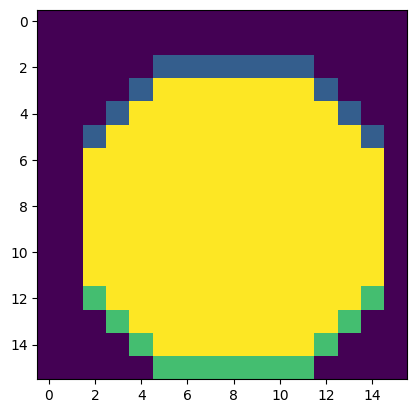

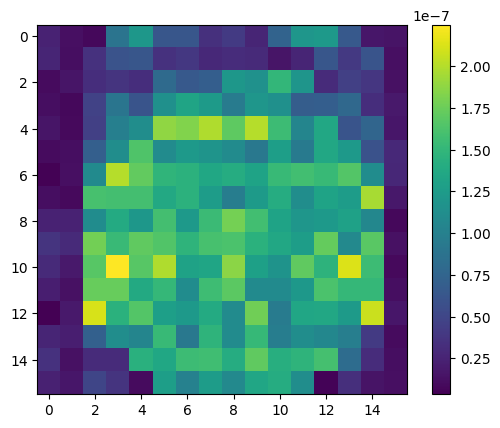

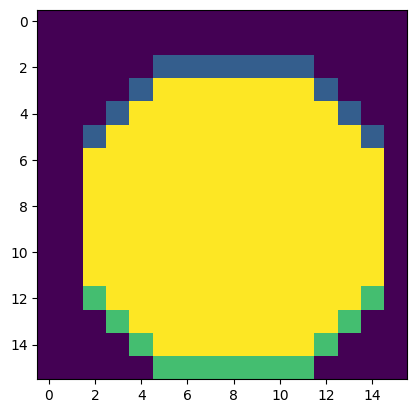

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(images_ift.real)

plt.figure()
plt.imshow(zz_ift.real)

plt.figure()
plt.imshow(zz2_ift.real)

plt.figure()

plt.imshow(np.abs(zz_ift - zz2_ift))
plt.colorbar()
plt.figure()
plt.imshow(zz2_ift.real)

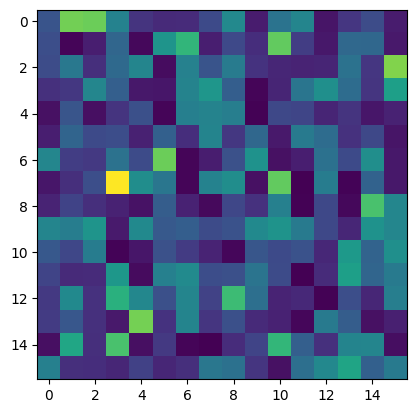

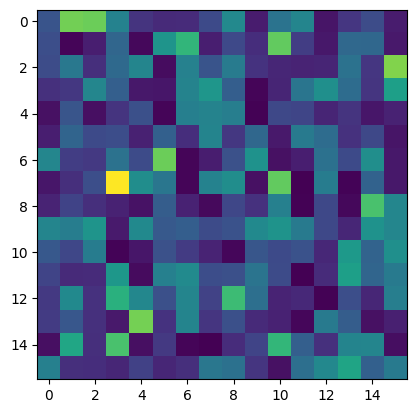

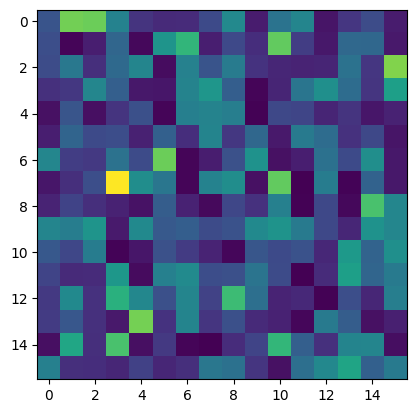

In [25]:
# from recovar import core
# core.translate_images(images[None], translations[1:2], image_shape)
import matplotlib.pyplot as plt
plt.imshow(np.abs(images))
plt.figure()
plt.imshow(np.abs(zz2))
plt.figure()
plt.imshow(np.abs(zz))

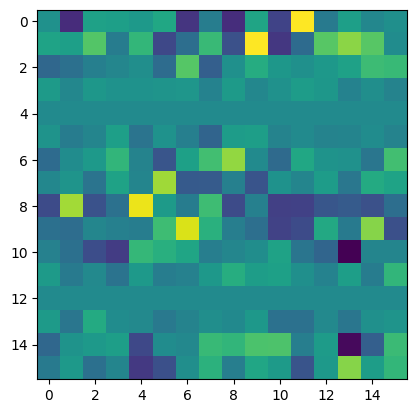

In [10]:
import matplotlib.pyplot as plt
plt.imshow(zz.real)

In [11]:
zz

Array([[ 8.10125396e-02+7.0823409e-09j, -1.09183943e+00-9.5451632e-08j,
         2.80126572e-01+2.4489442e-08j,  2.64227599e-01+2.3099512e-08j,
         1.93431050e-01+1.6910279e-08j,  3.54415387e-01+3.0983976e-08j,
        -1.00681257e+00-8.8018346e-08j, -1.78026661e-01-1.5563586e-08j,
        -1.06958282e+00-9.3505903e-08j,  3.27110976e-01+2.8596951e-08j,
        -8.55683625e-01-7.4806238e-08j,  1.59279096e+00+1.3924621e-07j,
        -2.24387020e-01-1.9616536e-08j,  2.61204332e-01+2.2835206e-08j,
        -4.69643623e-02-4.1057553e-09j,  5.76594397e-02+5.0407487e-09j],
       [ 3.11716676e-01-1.2911721e-01j,  2.65686274e-01-1.1005081e-01j,
         7.75207758e-01-3.2110140e-01j, -1.87108725e-01+7.7502936e-02j,
         5.65341651e-01-2.3417206e-01j, -8.09118211e-01+3.3514756e-01j,
        -3.63543451e-01+1.5058455e-01j,  6.06247723e-01-2.5111592e-01j,
        -7.18600452e-01+2.9765391e-01j,  1.60350633e+00-6.6419369e-01j,
        -9.84079778e-01+4.0761897e-01j, -3.97317469e-01+1.64574

In [12]:
zz2

Array([[ 8.10125396e-02+0.j        , -1.00872803e+00-0.41782883j,
         1.98079392e-01+0.19807939j,  1.01115525e-01+0.24411447j,
         0.00000000e+00+0.19343105j, -1.35628894e-01+0.32743713j,
         7.11924016e-01-0.711924j  ,  1.64475188e-01-0.06812785j,
         1.06958282e+00+0.j        , -3.02211136e-01-0.12517995j,
         6.05059683e-01+0.6050597j , -6.09534681e-01-1.4715469j ,
         0.00000000e+00+0.22438702j,  9.99585614e-02-0.24132133j,
        -3.32088210e-02+0.03320882j,  5.32703772e-02-0.02206531j],
       [ 3.37399691e-01+0.j        ,  2.65686244e-01+0.11005084j,
         5.93318224e-01+0.5933182j , -7.75029659e-02-0.18710871j,
         0.00000000e+00+0.6119213j ,  3.35147679e-01-0.8091181j ,
         2.78244078e-01-0.27824408j, -6.06247663e-01+0.251116j  ,
         7.77807415e-01+0.j        , -1.60350597e+00-0.6641939j ,
         7.53181934e-01+0.75318193j,  1.64574251e-01+0.3973174j ,
        -0.00000000e+00-0.8682021j ,  4.40044791e-01-1.0623622j ,
         

In [13]:
zz - zz2

Array([[ 0.00000000e+00+7.08234094e-09j, -8.31114054e-02+4.17828739e-01j,
         8.20471793e-02-1.98079363e-01j,  1.63112074e-01-2.44114444e-01j,
         1.93431050e-01-1.93431035e-01j,  4.90044296e-01-3.27437103e-01j,
        -1.71873665e+00+7.11923957e-01j, -3.42501849e-01+6.81278333e-02j,
        -2.13916564e+00-9.35059035e-08j,  6.29322112e-01+1.25179976e-01j,
        -1.46074331e+00-6.05059743e-01j,  2.20232558e+00+1.47154701e+00j,
        -2.24387020e-01-2.24387035e-01j,  1.61245763e-01+2.41321355e-01j,
        -1.37555413e-02-3.32088247e-02j,  4.38906252e-03+2.20653173e-02j],
       [-2.56830156e-02-1.29117206e-01j,  2.98023224e-08-2.20101655e-01j,
         1.81889534e-01-9.14419651e-01j, -1.09605759e-01+2.64611661e-01j,
         5.65341651e-01-8.46093357e-01j, -1.14426589e+00+1.14426565e+00j,
        -6.41787529e-01+4.28828627e-01j,  1.21249533e+00-5.02231956e-01j,
        -1.49640787e+00+2.97653913e-01j,  3.20701218e+00+2.38418579e-07j,
        -1.73726177e+00-3.45562965e-0

In [18]:
zz2 - images

Array([[-7.32787788e-01+0.j        , -8.93064141e-02+0.03699193j,
         2.75583148e-01-0.27558315j, -2.78482437e-01+0.672316j  ,
         0.00000000e+00-0.28688082j, -1.46287858e-01-0.35317016j,
        -1.47168541e+00-1.4716853j , -8.92311186e-02-0.03696074j,
        -4.73050654e-01+0.j        ,  6.59858584e-01-0.27332234j,
        -2.57677853e-01+0.25767785j, -6.28040731e-02+0.15162243j,
         0.00000000e+00+0.05395995j, -5.54953575e-01-1.3397762j ,
         3.38853419e-01+0.33885342j, -7.87658691e-01-0.3262589j ],
       [ 2.55682260e-01+0.j        ,  2.57902890e-01-0.10682687j,
        -1.70717210e-01+0.17071721j, -2.83006206e-02+0.06832375j,
         0.00000000e+00-0.09520563j,  3.06668356e-02+0.07403629j,
         2.49844015e-01+0.24984398j, -4.08523083e-01-0.16921578j,
        -7.12430835e-01+0.j        ,  4.47625041e-01-0.18541238j,
        -7.52965450e-01+0.75296557j, -2.25276291e-01+0.5438649j ,
         0.00000000e+00+0.01213543j,  2.81169534e-01+0.6788032j ,
         

In [11]:
zz

Array([[-0.5001324 , -1.3597883 , -1.2380376 ,  0.15509816, -0.81826395,
        -0.18324125,  1.0650054 ,  0.5525504 ,  0.5462495 , -0.3331034 ,
         2.2835262 , -1.2600467 , -0.1490634 ,  0.27004755,  0.01269406,
         0.59460986],
       [-0.2930674 ,  1.0417849 ,  0.6545924 , -1.3174285 , -0.1738749 ,
        -1.290794  , -0.80717254,  0.9356851 , -0.9162681 ,  1.0071119 ,
        -0.0402077 , -2.071015  , -0.59049225, -0.52202755, -1.0324434 ,
         1.1012015 ],
       [-0.39333105,  0.79830486,  1.4845008 ,  0.3166993 , -0.3119305 ,
         0.9557524 ,  0.29664594, -1.8315774 , -0.5651391 ,  0.440353  ,
         0.32719845,  0.77483   ,  0.3619021 ,  0.21194611,  0.13775331,
        -0.52927   ],
       [ 2.245849  , -0.66762286,  1.0618918 ,  0.598077  , -0.03861399,
         1.9360032 , -0.31343123, -0.10289393,  0.05685399, -0.79681313,
        -0.27008432, -0.7135858 ,  0.04568695,  0.49064544, -0.18304883,
         1.0284085 ],
       [ 0.6718524 , -0.3059054 , -0

In [2]:
import matplotlib.pyplot as plt
plt.imshow(zz.reshape(image_shape))

In [31]:
np.linalg.norm(zz2 -images.reshape(-1))

16.21049

In [32]:
np.linalg.norm(zz -zz2)

16.21049

In [17]:
zz2 - zz

Array([ 2.24570617e-01-0.05218051j,  1.21964961e-01-0.05377116j,
       -3.43184918e-01-0.05979131j,  3.42582941e-01+0.00608433j,
        6.47728086e-01+0.05214109j, -1.97397575e-01+0.04597701j,
       -1.29346862e-01-0.01691876j, -5.46820462e-01-0.01246638j,
       -3.38805616e-01+0.02908821j, -4.46732230e-02-0.01592902j,
        1.82450324e-01-0.05319325j,  4.26843315e-01-0.04352197j,
        6.00680709e-01+0.03521341j, -6.60389662e-03+0.0512641j ,
       -3.21890153e-02+0.06564112j, -7.86426663e-01+0.02236308j,
       -1.16325110e-01+0.01026266j,  1.44475043e-01-0.01384853j,
        2.43504569e-02+0.01825916j,  7.10990429e-02+0.01389171j,
       -1.34273916e-01+0.05694008j, -2.76776016e-01+0.0348064j ,
       -1.04504898e-01-0.02140396j, -1.01398326e-01-0.06181827j,
        1.14369653e-01-0.03845822j,  2.74810791e-01-0.03948987j,
       -1.94432750e-01+0.00093914j, -1.56477779e-01+0.09117284j,
        1.77548379e-01+0.07780351j,  7.34612569e-02-0.01488921j,
        4.03041869e-01-0.

In [5]:
pdb

Automatic pdb calling has been turned ON


In [5]:
pdb

Automatic pdb calling has been turned ON


In [2]:
zz

NameError: name 'zz' is not defined